# Building a Deep Convolutional Neural Network from scratch

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

## Preamble

This notebook is an introduction to building a convolutional neural network from scratch, for the purposes of binary image classification

## Objective

We're going to construct an CDNN to segment images into two classes: 'water' and 'not water'

### Load libraries

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

import s3fs
fs = s3fs.S3FileSystem(anon=True)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

This time we'll also load the [contrib.layers](https://www.tensorflow.org/api_guides/python/contrib.layers) which are high level functions for building neural network layers

In [2]:
import random
np.random.seed(0)
from tensorflow.contrib.layers import conv2d, conv2d_transpose, batch_norm

In [3]:
# "Convolution - Deconvolution Network"

## Model architecture

![](https://i.stack.imgur.com/lm5wv.png)

Convolutional layers apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. 

Then a ReLU activation function is applied to the output to introduce nonlinearities into the model.

Pooling layers downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. Max pooling extracts subregions of the feature map, keeps their maximum value, and discards all other values.

### Convolution network architecture

1. Convolutional layer 1
2. Batch normalization
3. Pooling layer 1
4. Residual layer 1
5. Pooling layer 2
6. Residual layer 2
7. Pooling layer 3
8. Residual layer 3

The convolutional layer applies 32, 3x3 filters with a reLU activation function

In [ ]:
#jlogan ReLU is now favored instead of Sigmoid for "squishification"

![](https://www.kdnuggets.com/wp-content/uploads/activation.png)

In [4]:
def conv(T, num_kernels, kernel_size, activation_fn=tf.nn.relu): 
    """
    2d convolution
    """
    return conv2d(T, num_kernels, kernel_size, activation_fn=activation_fn)

What is batch normalization?
* Essentially, normalizing the input layer by adjusting and scaling the activations.

Why do we use batch normalization?

* Batch normalization allows each layer of a network to learn by itself a little bit more independently of other layers.

* We can use higher learning rates because batch normalization makes sure that there’s no activation that’s gone really high or really low. And by that, things that previously couldn’t get to train, it will start to train.

* It reduces overfitting because it has a slight regularization effects. Similar to dropout, it adds some noise to each hidden layer’s activations. Therefore, if we use batch normalization, we will use less dropout, which is a good thing because we are not going to lose a lot of information. 

In [5]:
def bn(T):
    """
    batch normalization
    """
    return batch_norm(T, updates_collections=None)

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('dXB-KQYkzNU') ## 7 mins

Each residual layer consists of two sets of convolution followed by a batch normalization

![](https://cdn-images-1.medium.com/max/376/1*pUyst_ciesOz_LUg0HocYg.png)

In [6]:
def residual(T, num_kernels, kernel_size):
    T = conv(T, num_kernels, kernel_size)
    T = bn(T)
    T = conv(T, num_kernels, kernel_size, activation_fn=None)
    T = bn(T)
    return T

In [ ]:
YouTubeVideo('ZILIbUvp5lk')

The pooling layer performs max. pooling with a 2x2 filter and stride of 2

In [7]:
def pool(T):
    """
    max pooling with no overlap
    """
    return tf.nn.max_pool(T, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [8]:
## strided convolutions
YouTubeVideo('tQYZaDn_kSg') ## 9 mins

NameError: name 'YouTubeVideo' is not defined

In [9]:
## pooling layers
YouTubeVideo('8oOgPUO-TBY') ## 10 mins

NameError: name 'YouTubeVideo' is not defined

### Deconvolution network architecture

1. Unpooling layer 1
2. Transpose residual layer 1
3. Unpooling layer 2
4. Transpose residual layer 2
5. Unpooling layer 3
6. Transpose residual layer 3
7. Transpose convolution layer

An unpooling layer is a reverse convolution

In [10]:
def unpool(T):
    """
    inverse of pooling step
    """
    height, width = T.get_shape().as_list()[1:3]
    return tf.image.resize_images(T, (height*2, width*2))

Each transpose residual layer consists of two sets of transpose convolution and batch normalization

In [11]:
def residualT(T, num_kernels, kernel_size):
    T = convT(T, num_kernels, kernel_size)
    T = bn(T)
    T = convT(T, num_kernels, kernel_size, activation_fn=None)
    T = bn(T)
    return T

In [12]:
def convT(T, num_kernels, kernel_size, activation_fn=tf.nn.relu):
    """
    transpose of 2d convolution
    """
    return conv2d_transpose(T, num_kernels, kernel_size, activation_fn=activation_fn)

Utility functions

In [13]:
def gcd(a,b):
    """Compute the greatest common divisor of a and b"""
    while b > 0:
        a, b = b, a % b
    return a

def flatten(T):
    flat_size = np.prod(T.get_shape().as_list()[1:])
    return tf.reshape(T, [-1, flat_size])

Other functions for getting batches of images and masks, patches of pixels within images, and creating test and train data sets

In [14]:
## given an array of images and associated masks, choose one at random
def get_random_image_and_mask(images_and_masks):
    return random.choice(images_and_masks)

## get a randomly selected patch of pixels from an image, with given dimensions
def get_random_patch(images_and_masks, patch_height, patch_width):
    image, mask = get_random_image_and_mask(images_and_masks)
    
    image_height, image_width, image_channels = image.shape
    assert(image_channels == 3)
    
    x = np.random.randint(image_width - patch_width)
    y = np.random.randint(image_height - patch_height)
    
    image_patch = image[y:y+patch_height, x:x+patch_width]
    mask_patch  = mask [y:y+patch_height, x:x+patch_width]
    
    return image_patch, mask_patch

## select a random batch of images and masks
def get_random_batch(images_and_masks, batch_size, patch_height, patch_width):
    image_patches = []
    mask_patches = []
    
    for i in range(batch_size):
        image_patch, mask_patch = get_random_patch(images_and_masks, patch_height, patch_width)
        
        image_patches.append(image_patch)
        mask_patches.append(mask_patch)

    return image_patches, mask_patches

## create training and testing sets given user-specified split
def split_train_test(values, test_ratio = 0.2):
    # split [values] into [train values] + [test values]
    
    n = len(values)
    n_train = n - int(n*test_ratio)

    train = values[:n_train]
    test  = values[n_train:]
    
    return train, test

### Preparing a test and train data set

In [15]:
#jlogan  these are being downsampled by 0.125 for speed but you wouldnt necessarily do this for real datasets
image_files = [f for f in fs.ls('cdi-workshop/semseg_data/ontario/train') if f.endswith('.JPG')]
image_files.extend([f for f in fs.ls('cdi-workshop/semseg_data/ontario/test') if f.endswith('.JPG')])
imsize = 0.125
len(image_files)

48

In [16]:
from scipy.misc import imresize
from imageio import imread

images = []
for file in image_files:
    with fs.open(file, 'rb') as f:
        images.append(imresize(imread(f), imsize))

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Load in the classification data

In [17]:
class_files = [f for f in fs.ls('cdi-workshop/semseg_data/ontario/train') if f.endswith('.mat')]
class_files.extend([f for f in fs.ls('cdi-workshop/semseg_data/ontario/test') if f.endswith('.mat')])
len(class_files)

48

The classes are stored in .mat format. Water is class '2'

We load in each file, binarize it (water=0, not water=1), and resize it

In [18]:
from scipy.io import loadmat
classes = []
for file in class_files:
    print("Working on %s" % file.split(os.sep)[-1])
    with fs.open(file, 'rb') as f:
        tmp = (loadmat(f)['class']!=2).astype('uint8')
        classes.append(imresize(tmp, imsize).astype('int'))

Working on A2013170_geotag_mres.mat


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Working on A2013473_geotag_mres.mat
Working on A2013540_geotag_mres.mat
Working on A2013594_geotag_mres.mat
Working on A2013649_geotag_mres.mat
Working on A2013657_geotag_mres.mat
Working on A2013671_geotag_mres.mat
Working on A2013697_geotag_mres.mat
Working on A2013709_geotag_mres.mat
Working on A2013733_geotag_mres.mat
Working on A2013743_geotag_mres.mat
Working on A2013773_geotag_mres.mat
Working on A2013900_geotag_mres.mat
Working on A2013960_geotag_mres.mat
Working on A2014128_geotag_mres.mat
Working on A2014153_geotag_mres.mat
Working on A2014155_geotag_mres.mat
Working on A2014158_geotag_mres.mat
Working on A2014160_geotag_mres.mat
Working on A2014162_geotag_mres.mat
Working on A2014164_geotag_mres.mat
Working on A2014166_geotag_mres.mat
Working on A2014168_geotag_mres.mat
Working on A2014858_geotag_mres.mat
Working on A2013218_geotag_mres.mat
Working on A2013504_geotag_mres.mat
Working on A2013562_geotag_mres.mat
Working on A2013638_geotag_mres.mat
Working on A2013653_geotag_m

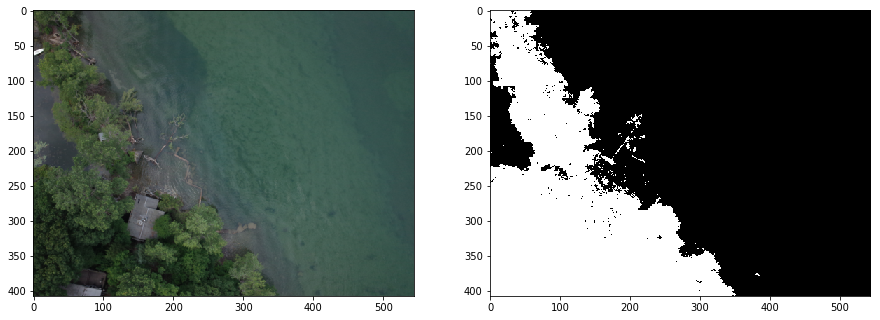

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(images[0])
plt.subplot(122); plt.imshow(classes[0], cmap=plt.cm.binary_r)

Create a list of all images and masks together

In [20]:
images_and_masks = []
for image, mask in zip(images, classes):
    images_and_masks.append((image.astype(np.float32)/255.0, mask.astype(np.float32)/255.0))

In [21]:
len(images_and_masks)

48

### Training function:

In [22]:
def train(patch_width, batch_size, kernel_size, num_kernels, n, n_batches, imsize, train_im_n_masks, test_im_n_masks):

   patch_height = patch_width

   image_patch_init = tf.placeholder(tf.float32, [None, patch_width, patch_height, 3])
   mask_patch_init  = tf.placeholder(tf.float32, [None, patch_width, patch_height, 1])

   # set up residual convolutional network architecture 
   T = image_patch_init
   T = conv(T, num_kernels, kernel_size) ##16
   T = bn(T)
    
   ##cycle through n pooling-residual steps
   for _ in range(n):
      T = pool(T)
      T += residual(T, num_kernels, kernel_size) ##16

   ##cycle through n unpooling-residual steps
   for _ in range(n):
      T = unpool(T)
      T += residualT(T, num_kernels, kernel_size) ##16
    
   T = convT(T, 1, kernel_size, activation_fn=None)

   pred_mask_patches = T

   ##l2 loss
   diff = tf.abs(pred_mask_patches - mask_patch_init)
   loss_fn = tf.reduce_mean(diff**2)

   # adam optimizer requires the least amount of work to train
   optimizer = tf.train.AdamOptimizer()
   trainer = optimizer.minimize(loss_fn)

   # make a tensorflow session
   sess = tf.InteractiveSession()

   # initialize weights and stuff
   initializer = tf.global_variables_initializer()
   sess.run(initializer)

   # train the model
   last_print_time = 0
   for batch in range(n_batches + 1):
      # make a batch of patches
      image_patches, mask_patches = get_random_batch(train_im_n_masks, batch_size, patch_height, patch_width)

      #deal with the possibility of empty patches
      ind = []
      for k in range(len(mask_patches)):
         if mask_patches[k].size==0: 
            ind.append(k)
 
      for x in ind[::-1]:
         del mask_patches[x]
         del image_patches[x]

      try:
         # feed it to the neural net
         feed_dict = {
           image_patch_init: image_patches,
           mask_patch_init: mask_patches,
         }
         _, train_loss = sess.run([trainer, loss_fn], feed_dict=feed_dict)

         # print training error every second
         time_since_last_print = time.clock() - last_print_time
         if time_since_last_print > 1.0:
            print("batch number =%5d, training loss =%f"%(batch, train_loss))
            last_print_time = time.clock()

         # check test error every 50 iterations
         if batch % 50 != 0: continue

         # check test loss
         image_patches, mask_patches = get_random_batch(test_im_n_masks, batch_size, patch_height, patch_width)

         #deal with the possibility of empty patches
         ind = []
         for k in range(len(mask_patches)):
            if mask_patches[k].size==0: 
               ind.append(k)

         for x in ind[::-1]:
            del mask_patches[x]
            del image_patches[x]

         feed_dict = {
           image_patch_init: image_patches,
           mask_patch_init: mask_patches,
         }
    
         test_loss = sess.run(loss_fn, feed_dict=feed_dict)

         print("#"*40)
         print("testing loss =%f"%test_loss)
         print("#"*40)

      except:
         pass

   # save the model
   saver = tf.train.Saver()

   tf.add_to_collection('loss', loss_fn)
   tf.add_to_collection('train', trainer)
   tf.add_to_collection('pred_mask_patches', pred_mask_patches)
   tf.add_to_collection('image_patch_init', image_patch_init)
   tf.add_to_collection('mask_patch_init', mask_patch_init)

   try:
      os.mkdir("model_"+str(imsize)+"_"+str(patch_width))
   except:
      pass

   saver.save(sess, "model_"+str(imsize)+"_"+str(patch_width)+os.sep+"model")
   sess.close()
   tf.reset_default_graph()
   del sess


### Train the model

we'll train with different patch widths and associated batch sizes

Options

In [23]:
n_batches  = 600 #400 
# size of kernel in convolution  (physical size in pixels)
kernel_size = 3 
# number of kernels of size kernel_size x kernel_size
num_kernels = 16 
#number of pooling layers  (also means 3 conv layers and 3 residual layers)
n = 3 

Split the data set into training and testing sets

In [24]:
train_im_n_masks, test_im_n_masks = split_train_test(images_and_masks, test_ratio=.2)
#del images_and_masks

In [25]:
print(len(train_im_n_masks))
print(len(test_im_n_masks))

39
9


What's the structure of this data?

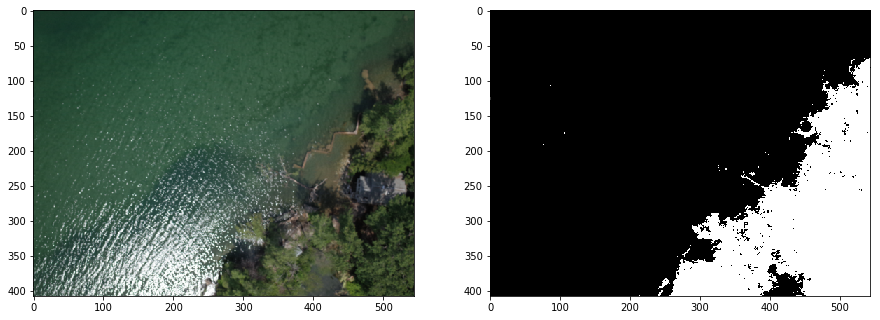

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(test_im_n_masks[0][0])
plt.subplot(122); plt.imshow(test_im_n_masks[0][1], cmap=plt.cm.binary_r)

Train using different patch widths

In [27]:
#train using different sizes of patches using these sizes, and we'll end up wih five different models

for patch_width in [16, 32, 64, 128, 256]:

   print("Procesing: %i" % patch_width)
   if patch_width == 16:
      batch_size = 2000 #1000
   elif patch_width == 32:
      batch_size = 1000 #500
   elif patch_width == 64:
      batch_size = 500 #250   
   elif patch_width == 128:
      batch_size = 250 ##125
   elif patch_width == 256:
      batch_size = 125 ##125
        
   train(patch_width, batch_size, kernel_size, num_kernels, n, n_batches, imsize, train_im_n_masks, test_im_n_masks)

Procesing: 16
Procesing: 32
Procesing: 64
Procesing: 128
Procesing: 256


### Test the model

First we need to create a function that uses the model to make the prediction

In [28]:
#make prediction on unseen data

def make_pred(impad, height, width, kernel_size, num_patches, path):

   # load the model 
   sess = tf.Session() #InteractiveSession()
   new_saver = tf.train.import_meta_graph("./%s/model.meta"%path)
   new_saver.restore(sess, tf.train.latest_checkpoint('./%s/'%path))

   pred_mask_patches = tf.get_collection('pred_mask_patches')[0]
   image_patch_init = tf.get_collection('image_patch_init')[0]
   mask_patch_init = tf.get_collection('mask_patch_init')[0]

   patch_height = patch_width = kernel_size

   # Only the prediction at the center of a patch is correct
   # so we make a weight patch to weight the predicted mask patch appropriately.
   x = np.linspace(-1, +1, patch_width)
   y = np.linspace(-1, +1, patch_height)
   X, Y = np.meshgrid(x, y)
   dist = smoothstep(1.3, 0.3, np.sqrt(X*X + Y*Y))
   weight_patch = dist.reshape((patch_height, patch_width, 1))

   # take random patches from within the orig image bounds
   image_patches = []
   patch_pos = []
   for i in range(num_patches):
      x = np.random.randint(width  + patch_width) + width  - patch_width
      y = np.random.randint(height + patch_height) + height - patch_height
    
      image_patch = impad[y:y+patch_height, x:x+patch_width]
    
      image_patches.append(image_patch)
      patch_pos.append((y, x))

   # predict the object mask for those patches
   feed_dict = {image_patch_init: image_patches}
   mask_patches = sess.run(pred_mask_patches, feed_dict=feed_dict)

   sess.close()

   # stitch the object masks back together while weighting them
   pred_mask = np.zeros(impad.shape)
   weight = np.zeros(impad.shape)

   w = np.median(weight_patch)
   for mask_patch, p in zip(mask_patches, patch_pos):
      y, x = p

      mask_patch[mask_patch<0] = np.nan
      pred_mask[y:y+patch_height*2, x:x+patch_width*2, :] += np.nanmedian(mask_patch)*w
      weight[y:y+patch_height*2, x:x+patch_width*2, :] += w

   # only need first layers
   pred_mask = np.mean(pred_mask, axis=2)
   weight = np.mean(weight, axis=2)

   # normalize the masks by weight
   pred_mask /= weight + 0.001

   # extract just the center image 
   pred_mask = pred_mask[1*height:2*height, 1*width:2*width] #, :]

   tf.reset_default_graph()
   del sess
   return pred_mask/np.max(pred_mask)

In [29]:
##======================================================
def smoothstep(edge0, edge1, x):
    # https://www.opengl.org/sdk/docs/man/html/smoothstep.xhtml
    t = np.clip((x - edge0)/(edge1 - edge0), 0.0, 1.0)
    return t*t*(3.0 - 2.0*t)

In [30]:
kernel_size = 32
num_patches = 1000

patch_height = kernel_size

path = 'model_'+str(imsize)+'_'+str(kernel_size)

In [31]:
testimage = train_im_n_masks[0][0]

One more function! This one pads an image using mirroring, to minimize edge effects

In [32]:
def get_padded_image(testimage):
    height, width, n_channels = testimage.shape
    impad = np.zeros((height*3, width*3, n_channels))

    impad[1*height:2*height, 1*width:2*width, :] = testimage
    impad[0*height:1*height, 1*width:2*width, :] = np.flipud(testimage)
    impad[2*height:3*height, 1*width:2*width, :] = np.flipud(testimage)
    impad[1*height:2*height, 0*width:1*width, :] = np.fliplr(testimage)
    impad[1*height:2*height, 2*width:3*width, :] = np.fliplr(testimage)

    impad[0*height:1*height, 0*width:1*width, :] = np.flipud(np.fliplr(testimage))
    impad[2*height:3*height, 0*width:1*width, :] = np.flipud(np.fliplr(testimage))
    impad[0*height:1*height, 2*width:3*width, :] = np.flipud(np.fliplr(testimage))
    impad[2*height:3*height, 2*width:3*width, :] = np.flipud(np.fliplr(testimage))
    
    return height, width, impad

In [33]:
height, width, impad = get_padded_image(testimage)

Get a prediction:

In [34]:
P = make_pred(impad, height, width, kernel_size, num_patches, path)

INFO:tensorflow:Restoring parameters from ./model_0.125_32/model


Now we can plot to see the prediction

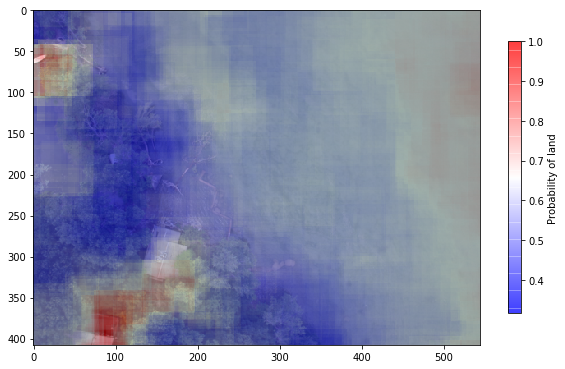

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(P, alpha=0.5, cmap=plt.cm.bwr)
cb = plt.colorbar(shrink=0.5)
cb.set_label('Probability of land')

Let's look at a few more:

INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model


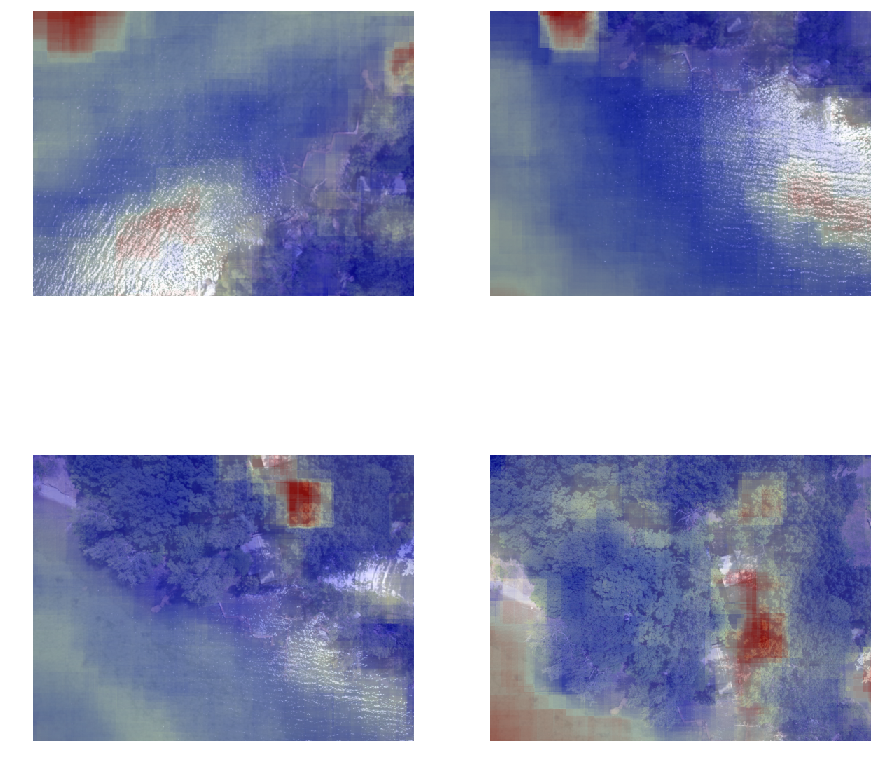

In [36]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    testimage = test_im_n_masks[i][0]
    height, width, impad = get_padded_image(testimage)
    P = make_pred(impad, height, width, kernel_size, num_patches, path)
    axi.imshow(testimage)
    axi.imshow(P, alpha=0.5, cmap=plt.cm.bwr)
    axi.axis('off')

### Multi-scalar prediction

Since we trained at multiple scales, we can also test at those scales and merged predictions

In [37]:
##testimage = test_im_n_masks[1][0]
testimage = train_im_n_masks[0][0]

height, width, impad = get_padded_image(testimage)

kernel_size = [32, 64, 128, 256]

num_patches = [2000, 1000, 500, 250]

patch_height = np.min(kernel_size)

Run the model for all kernel sizes

In [38]:
P = []
for n in range(len(kernel_size)):
    path = 'model_'+str(imsize)+'_'+str(kernel_size[n])
    P.append(make_pred(impad, height, width, kernel_size[n], num_patches[n], path))

for n in range(len(kernel_size)):
    P[n][P[n]==0] = np.nan

INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_64/model


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


INFO:tensorflow:Restoring parameters from ./model_0.125_128/model
INFO:tensorflow:Restoring parameters from ./model_0.125_256/model


Let's take a look at the outputs:

/opt/conda/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/opt/conda/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/opt/conda/lib/python3.6/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/conda/lib/python3.6/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/conda/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


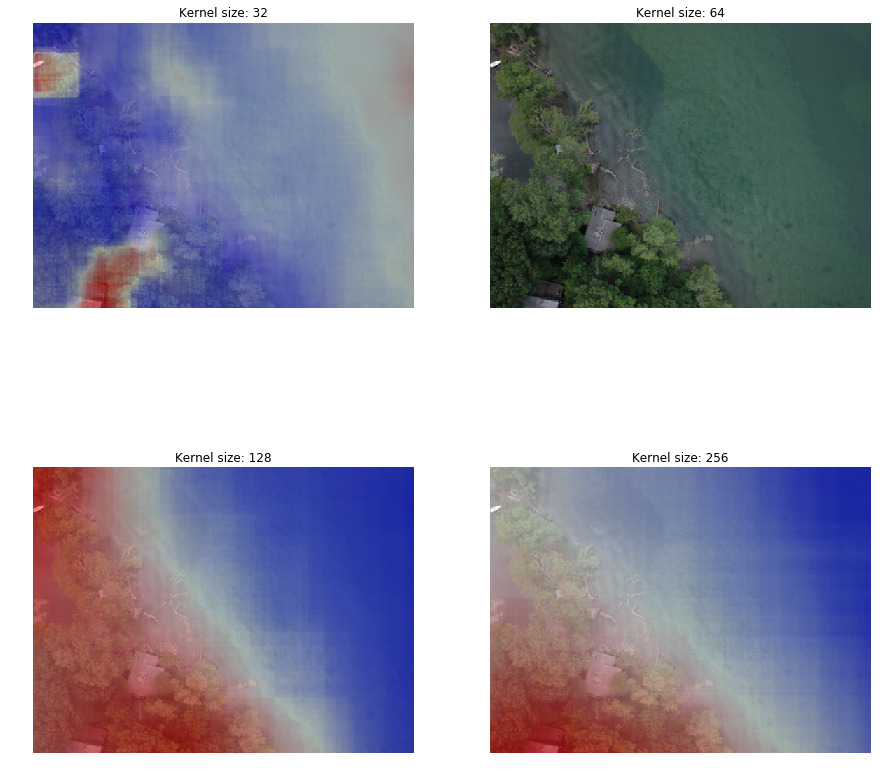

In [39]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    axi.imshow(testimage)
    axi.imshow(P[i], alpha=0.5, cmap=plt.cm.bwr)
    axi.axis('off')
    axi.set(title='Kernel size: '+str(kernel_size[i]))

Compute a median per pixel through the stack

In [40]:
pred = np.nanmean(np.dstack(P), axis=2)

In [41]:
# =========================================================
def rescale(dat,mn,mx):
    '''
    rescales an input dat between mn and mx
    '''
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

In [42]:
pred = rescale(pred, 0, 1)

Let's plot

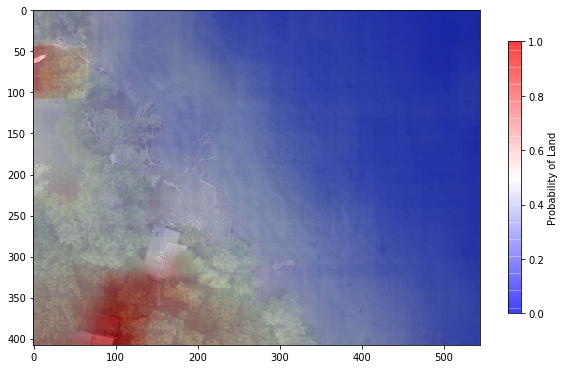

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(pred, alpha=0.5, cmap=plt.cm.bwr)
cb = plt.colorbar(shrink=0.5)
cb.set_label('Probability of Land')

### Creating the mask

#### Global threshold

The simplest way would be to define a global threshold:

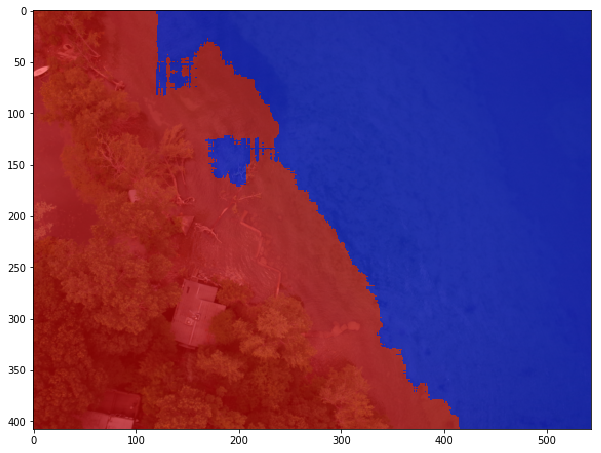

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(pred>.3, alpha=0.5, cmap=plt.cm.bwr)
cb.set_label('Land')

This isn't optimal, and probably wouldn't generalize well

#### Generative

Another option is to use a generative ML algorithm to model the likelihood of the 2 classes

Let's use a Gaussian Mixture model, which is something we have used before. The following function will read the image and associated land probability, and fit a N component GMM

In [48]:
from sklearn import mixture

##======================================================
def GMM(im1, im, numclusters, maxiter):
   """
   takes an RGB image and a probability layer and computes
   an N-component (4-dimensional) Gaussian mixture model
   then recasts predictions in a 2D, N-component label map
   """
   
   X = np.c_[im1.flatten(), im[:,:,0].flatten(), im[:,:,1].flatten(), im[:,:,2].flatten()] 

   # Fit a Gaussian mixture
   dpgmm = mixture.GaussianMixture(n_components=numclusters, covariance_type='full', max_iter=maxiter).fit(X) 
   Yb = dpgmm.predict(X)
   return  Yb.reshape(im.shape[0], im.shape[1])##, probs.reshape(im.shape[0], im.shape[1],numclusters)

As an example, below we fit a 5-component GMM, similar to what we did on Day 1

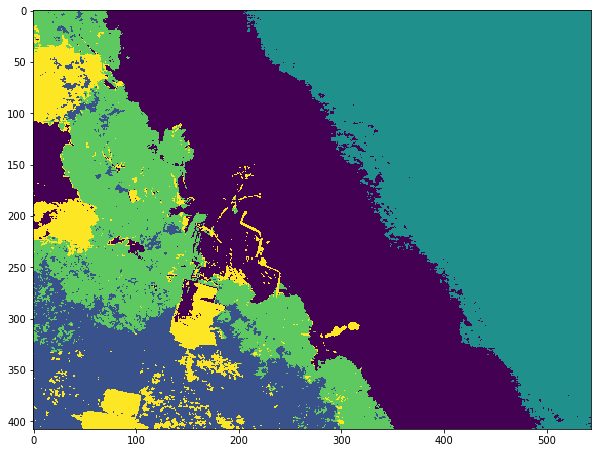

In [49]:
numclusters = 5 #number of clusters for GMM
maxiter = 50 #maximum iterations in GMM

p = GMM(pred, testimage, numclusters, maxiter)

plt.figure(figsize=(10,10))
plt.imshow(p)

This function below will compute the median probability associated with each component, then mask the probabilities less than a specified threshold

In [50]:
##======================================================
def GMM_mask_multi(pred_mask, image, maxiter, patch_height, prob_thres, numclusters):
   """
   implements GMM with nan replacement and checks on outputs
   """

   pred_mask[np.isinf(pred_mask)] = np.nanmean(pred_mask)
   pred_mask[np.isnan(pred_mask)] = np.nanmean(pred_mask)

   p = GMM(pred_mask, image, numclusters, maxiter)

   c = [np.nanmedian(pred_mask[p==k]) for k in range(numclusters)]

   if (np.all(np.asarray(c)>prob_thres) or np.all(np.asarray(c)<prob_thres)):
      prob_thres = np.mean(c)
      print("Revising probability threshold to %f"%prob_thres)

   mask = np.zeros(np.shape(p))
   for val in np.where(np.asarray(c)>prob_thres)[0]:
      mask[p==val] = 1

   return mask

In [51]:
prob_thres = 0.5 #greater than this is kept in multi-part GMM

In [52]:
p = GMM_mask_multi(pred, testimage, maxiter, patch_height, prob_thres, numclusters)

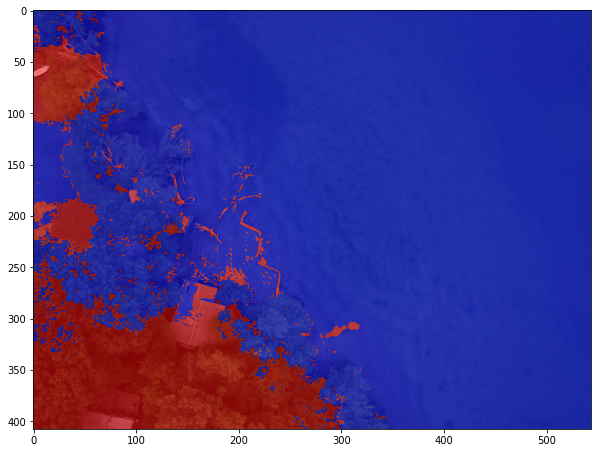

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(p, alpha=0.5, cmap=plt.cm.bwr)
cb.set_label('Land')